# Installing Neptune

In [ ]:
!pip install neptune-client

In [ ]:
!pip install pytorch-ignite

# Main

Libraries

In [3]:
from numpy.random import permutation
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import neptune.new as neptune
import hashlib
from ignite.engine import create_supervised_evaluator
from ignite.metrics import Accuracy, ConfusionMatrix
import numpy as np
import seaborn as sns

## Step 1: Initialize Neptune and create new run

In [ ]:
run = neptune.init(project = 'common/pytorch-integration', api_token='ANONYMOUS')

https://app.neptune.ai/common/pytorch-integration/e/PYTOR1-9


Helper functions

In [4]:
def save_model(model, name ='model.txt'):
    print(f'Saving model arch as {name}.txt')
    with open(f'{name}_arch.txt', 'w') as f:  f.write(str(model))
    print(f'Saving model weights as {name}.pth')
    torch.save(model.state_dict(), f'./{name}.pth')

Config

In [5]:
data_dir = 'data/CIFAR10'
compressed_ds = './data/CIFAR10/cifar-10-python.tar.gz'
data_tfms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            
        ])
    }
parameters = {'lr': 1e-2,
              'bs': 128,
              'input_sz': 32 * 32 * 3,
              'n_classes': 10,
              'epochs': 2,
              'model_filename': 'basemodel',
              'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
              }

Model & Dataset

In [6]:
class BaseModel(nn.Module):
    def __init__(self, input_sz, hidden_dim, n_classes):
        super(BaseModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_sz, hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, n_classes)
        )

    def forward(self, input):
        x = input.view(-1, 32* 32 * 3)
        return self.main(x)


In [7]:
trainset = datasets.CIFAR10(data_dir, transform=data_tfms['train'], 
                            download=True)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=parameters['bs'],
                                          shuffle=True, num_workers=2)
validset = datasets.CIFAR10(data_dir, train=False,
                            transform=data_tfms['train'],
                            download=True)
validloader = torch.utils.data.DataLoader(validset, 
                                          batch_size=parameters['bs'], 
                                          num_workers=2)
      
dataset_size = {'train': len(trainset), 'val': len(validset)}


Extracting data/CIFAR10/cifar-10-python.tar.gz to data/CIFAR10
Files already downloaded and verified


In [8]:
model = BaseModel(parameters['input_sz'], parameters['input_sz'], parameters['n_classes']).to(parameters['device'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=parameters['lr'])

## Step 2: Log config & hyperparameters



In [ ]:
run['config/dataset/path'] = data_dir
run['config/dataset/transforms'] = data_tfms
run['config/dataset/size'] = dataset_size
run['config/model'] = type(model).__name__
run['config/criterion'] = type(criterion).__name__
run['config/optimizer'] = type(optimizer).__name__
run['config/hyperparameters'] = params


## Step 3: Log losses and metrics 
Training Loop

In [9]:
def fit(model, optimizer, criterion):
      

      epoch_loss = 0.0
      epoch_acc = 0.0
      best_acc = 0.0

      
      for epoch in range(parameters['epochs']):
          running_loss = 0.0
          running_corrects = 0

          for i, (x, y) in enumerate(trainloader, 0):
              x, y = x.to(parameters['device']), y.to(parameters['device'])
              optimizer.zero_grad()
              outputs = model.forward(x)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, y)
              acc = (torch.sum(preds == y.data)) / len(x)

              # Log batch loss
              run["training/batch/loss"].log(value = loss)
              # Log batch acc
              run["training/batch/acc"].log(value = acc)

              loss.backward()
              optimizer.step()
            
              running_loss += loss.item()
              running_corrects += torch.sum(preds == y.data)
              
          epoch_loss = running_loss/dataset_size['train']
          epoch_acc = running_corrects.double().item() / dataset_size['train']

          # Log epoch loss
          run[f"training/epoch/loss"].log(value = epoch_loss, step = epoch + 1)
          # Log epoch acc
          run[f"training/epoch/acc"].log(value = epoch_acc, step = epoch + 1)

          print(f'Epoch:{epoch+1}, Loss: {epoch_loss}, Acc: {epoch_acc}')
          if epoch_acc > best_acc:
              best_acc = epoch_acc
              save_model(model, parameters['model_filename'])
              print('Saving model -- Done!')

      # Log model arch and weight files
      run[f"io_files/artifacts/{parameters['model_filename']}_arch"].upload(f"./{parameters['model_filename']}_arch.txt")
      run[f"io_files/artifacts/{parameters['model_filename']}"].upload(f"./{parameters['model_filename']}.pth")
      

In [10]:
if torch.cuda.is_available(): torch.cuda.empty_cache()
fit(model, optimizer, criterion)

Epoch:1, Loss: 0.015879566435813904, Acc: 0.29168
Saving model arch as basemodel.txt
Saving model weights as basemodel.pth
Saving model -- Done!
Epoch:2, Loss: 0.013701479275226592, Acc: 0.38574
Saving model arch as basemodel.txt
Saving model weights as basemodel.pth
Saving model -- Done!


## Step 4: Log images 

### Predicitions

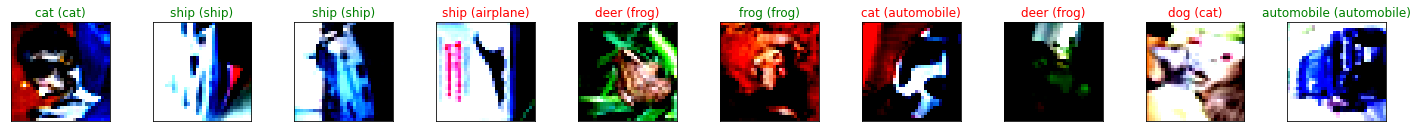

In [34]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog','horse','ship','truck']
dataiter = iter(validloader)
images, labels = dataiter.next()
images_arr = []
labels_arr = []
pred_arr = []
model.eval()
# moving model to cpu for inference 
if torch.cuda.is_available(): model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,10):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].squeeze().permute(2,1,0).numpy().clip(0,1))
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))

fig.savefig('predictions.jpg')

# Log image with predictions
run['io_files/artifacts/predictions'].upload('predictions.jpg')

### confusion matrix

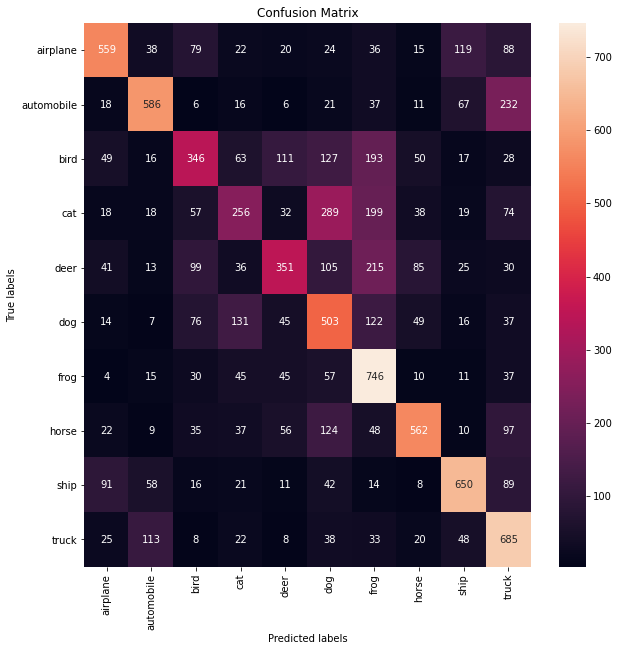

In [ ]:
metrics = {
    'accuracy':Accuracy(),
    'cm':ConfusionMatrix(num_classes=10)
}
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=parameters['device'])

val_evaluator.run(validloader)

metrics = val_evaluator.state.metrics
cm = metrics['cm']
cm = cm.numpy()
cm = cm.astype(int)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog','horse','ship','truck']
fig, ax = plt.subplots(figsize=(10,10))  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(classes,rotation=90)
ax.yaxis.set_ticklabels(classes,rotation=0)

fig.savefig('confusion_matrix.jpg')

# Log confusion matrix
run['io_files/artifacts/confusion_matrix'].upload('confusion_matrix.jpg')

## Stopping run

In [ ]:
run.stop() # No need in *.py